In [1]:
# jupyter lab에서 자동완성이 않될때 사용하는 코드
%config Completer.use_jedi = False

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision

from unet import UNet
import func

In [3]:
from PIL import Image

In [4]:
class KneeDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        lst_all_data = os.listdir(self.path)
                
        lst_data = []
        lst_mask = []
        
        for data in lst_all_data:
            if 'mask' in data:
                lst_mask.append(data)
            else:
                lst_data.append(data)
                
        lst_data.sort()
        lst_mask.sort()
        
        self.lst_data = lst_data
        self.lst_mask = lst_mask
        
    def __len__(self):
        return len(self.lst_data)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.path, self.lst_data[idx])
        mask_path = os.path.join(self.path, self.lst_mask[idx])
        
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
        img = np.asarray(img, np.float32)
        img /= 255.0
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_CUBIC)
        mask = np.asarray(mask, np.float32)
        mask /= 255.0

        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        return img, mask

### dataset test

In [5]:
dataset = KneeDataset('./data/train/')

In [6]:
len(dataset)

630

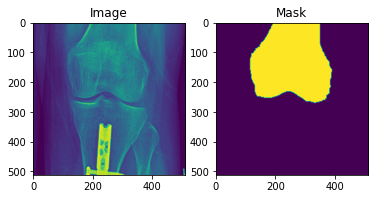

In [13]:
i = 6
img, mask = dataset[i]
# print(img.shape, mask.shape)

plt.subplot(121)
plt.title('Image')
plt.imshow(img)

plt.subplot(122)
plt.title('Mask')
plt.imshow(mask)

plt.show()

In [12]:
batch_size = 1
num_epoch = 1

lr = 0.001
momentum = 0.9

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [14]:
base_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [15]:
dataset = KneeDataset('./data/train/', transform=base_transform)

In [107]:
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [108]:
# for i, j in train_data_loader:
#     print(i.shape, j.shape)
#     print(type(j))
#     break

In [109]:
net = UNet().to(device)

In [110]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [115]:
import model

net = model.UNet().to(device)

In [ ]:
for epoch in range(1, num_epoch+1):
    net.train()
    for img, mask in train_data_loader:
        inputs = img.to(device)
        labels = mask.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    pritn(f"epoch: {epoch}/{num_epoch}, loss: {loss}")